This notebook performs the following steps:

- Imports necessary libraries for data manipulation, visualization, and machine learning.
- Defines utility functions to load change events from a JSON file, extract a variety of features into a DataFrame, and plot clusters.
- Loads change events, extracts features, and removes incomplete data.
- Standardizes the features and uses UMAP to reduce dimensionality for clustering and visualization.
- Applies Gaussian Mixture Model clustering to assign cluster labels.
- Updates the original events with the new cluster labels and saves the results to a new JSON file.

In [1]:
# Install missing packages if required: UMAP with pip install umap-learn in notebook

# !python -m pip install umap-learn scikit-learn pandas matplotlib

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap  # UMAP for dimensionality reduction

c:\Users\nc298\AppData\Local\anaconda3\envs\m4dvap\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
def load_change_events(change_events_file):
    """
    Load the change events from a JSON file.
    """
    if not os.path.exists(change_events_file):
        raise FileNotFoundError(f"{change_events_file} does not exist")
    with open(change_events_file, 'r') as f:
        events = json.load(f)
    return events

def extract_features(events):
    """
    Convert the change events into a feature matrix.
    This example assumes each event contains an "object_id".
    The features include:
      - Basic event info (e.g., delta_t_hours, number_of_points)
      - Change magnitude statistics (mean, std, min, max, median, quant90, quant95, quant99)
      - Convex hull properties (hull surface area, volume, and ratio)
      - Geometric features from both epochs
    """
    rows = []
    for event in events:
        row = {}
        # Basic features
        # row['delta_t_hours'] = event.get('delta_t_hours', np.nan)
        # row['number_of_points'] = event.get('number_of_points', np.nan)
        
        # Change magnitude statistics
        change_mags = event.get('change_magnitudes', {})
        for stat in ['mean', 'std', 'min', 'max', 'median', 'quant90', 'quant95', 'quant99']:
            row[f'change_{stat}'] = change_mags.get(stat, np.nan)
        
        # Convex hull properties
        convex_hull = event.get('convex_hull', {})
        row['hull_surface_area'] = convex_hull.get('surface_area', np.nan)
        row['hull_volume'] = convex_hull.get('volume', np.nan)
        row['hull_surf_vol_ratio'] = convex_hull.get('surface_area_to_volume_ratio', np.nan)
        
        # Geometric features from both epochs (if available)
        geom = event.get('geometric_features_both_epochs', {})
        for feat in ['sum_of_eigenvalues', 'omnivariance', 'eigentropy', 'anisotropy',
                     'planarity', 'linearity', 'surface_variation', 'sphericity', 'verticality']:
            row[f'geom_{feat}'] = geom.get(feat, np.nan)
        
        # Keep the unique identifier
        row['object_id'] = event.get('object_id')
        row["event_type"] = event.get('event_type', np.nan)
        
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

### Relevant parameters

In [32]:
random_state=42

# Parameter for UMAP 
n_neighbors=50
min_dist=0.1
n_components_umap=2
metric = "manhattan" 
# Parameter for clustering
n_components_GMM=2

### Load the data

In [33]:
# Set current directory to the location of the notebook (works even if __file__ is not defined)
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

os.chdir(current_dir)

# Path to the unlabelled change events test file
change_events_file = "../test_data/change_events_unlabelled.json"

# Load the change events
events = load_change_events(change_events_file)

### Extract features from the events

In [34]:
# Extract features into a DataFrame
features_df = extract_features(events)

# Handle missing values by dropping them
features_df = features_df.dropna()
if features_df.empty:
    raise ValueError("No complete data available after dropping missing values.")

# Separate the identifier from features
features_df_without_id = features_df.drop(columns=["object_id","event_type"])

### Dimensionality reduction

In [35]:
# Standardize the feature set for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df_without_id.values)

# UMAP for enhanced clustering
# Reduce the dimensionality of the feature set using UMAP
reducer = umap.UMAP(n_neighbors=n_neighbors,
                    min_dist=min_dist,
                    n_components=n_components_umap, 
                    random_state=random_state,
                    metric=metric)
X_umap = reducer.fit_transform(X_scaled)

c:\Users\nc298\AppData\Local\anaconda3\envs\m4dvap\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\nc298\AppData\Local\anaconda3\envs\m4dvap\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Clustering

In [36]:

# Gaussian Mixture Model Clustering
gmm = GaussianMixture(n_components=n_components_GMM, random_state=random_state)
labels = gmm.fit_predict(X_umap)

features_df['event_type'] = labels


c:\Users\nc298\AppData\Local\anaconda3\envs\m4dvap\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


### Plot Clustering result for UMAP components 1 and 2

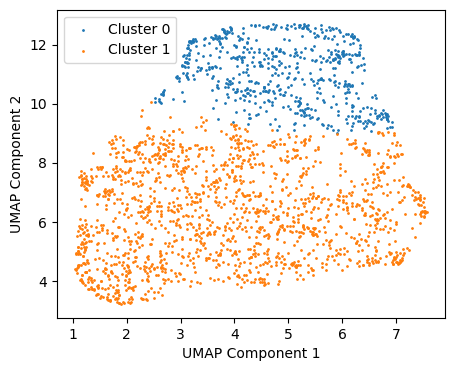

In [39]:
plt.figure(figsize=(5, 4))
unique_labels = np.unique(labels)
for label in unique_labels:
    mask = labels == label
    plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=f'Cluster {label}', s=1)
plt.legend()
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

### Save clustered change events

In [ ]:
# Create a mapping from object_id to the chosen cluster label (event_type)
label_mapping = dict(zip(features_df['object_id'], features_df['event_type']))

# Update the original events by matching them by object_id.
for event in events:
    obj_id = event.get('object_id')
    if obj_id in label_mapping:
        event['event_type'] = int(label_mapping[obj_id])
    else:
        # Mark events dropped due to missing features as None
        event['event_type'] = None

# Save the updated events to a new JSON file.
labelled_file = os.path.join(os.path.dirname(change_events_file), 'change_events_labelled_unsupervised.json')
with open(labelled_file, 'w') as f:
    json.dump(events, f, indent=4)
